# Build Custom Object Detector with Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

### Installing Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15837 (delta 30), reused 12 (delta 12), pack-reused 15781 (from 2)
Receiving objects: 100% (15837/15837), 6.40 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (11537/11537), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.6 ; cuda:  cu124
detectron2: 0.6


### Imports

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Let's get Our Dataset

[DATASET LINK](https://universe.roboflow.com/joseph-nelson/hard-hat-workers)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Detectron2_Dataset

/content/drive/MyDrive/Detectron2_Dataset


In [ ]:
!unzip /content/drive/MyDrive/Detectron2_Dataset/dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/001348_jpg.rf.1aaa9816491996825a47db9788df151d.jpg  
 extracting: train/001349_jpg.rf.a0408b75692819b5bfd8c2bb962eaf5d.jpg  
 extracting: train/001350_jpg.rf.de9536b247379a11b76fc8f444c4b713.jpg  
 extracting: train/001351_jpg.rf.a79f8541415bd4094b7d8435f6d9c1a9.jpg  
 extracting: train/001352_jpg.rf.b718c79a2fda13186e41a6cafd49fa13.jpg  
 extracting: train/001353_jpg.rf.47085a76256908fc10410be9f34ab7b4.jpg  
 extracting: train/001354_jpg.rf.03c92d8799e95f4ebf9473d19b71ab03.jpg  
 extracting: train/001355_jpg.rf.7da02fbe046934642d3aa6d524f7cf21.jpg  
 extracting: train/001356_jpg.rf.631c2ba8e2e94fda0a4d452557f281d2.jpg  
 extracting: train/001357_jpg.rf.8bd08ceb5ba66e05a38f06bdd82bb048.jpg  
 extracting: train/001358_jpg.rf.f1bcaa65ccf3775b2615c8704fd0f8ad.jpg  
 extracting: train/001359_jpg.rf.9ed6c7511943993d62be596571b64b5b.jpg  
 extracting: train/001360_jpg.rf.bfc59b1c8bd9752cae069e0a8f050f4d.jpg  
 extracting: 

In [ ]:
!cat /content/drive/MyDrive/Detectron2_Dataset/train/_annotations.coco.json

{"info":{"year":"2022","version":"10","description":"Exported from roboflow.ai","contributor":"Northeastern University - China","url":"https://public.roboflow.ai/object-detection/hard-hat-workers","date_created":"2022-10-18T17:17:06+00:00"},"licenses":[{"id":1,"url":"https://creativecommons.org/publicdomain/zero/1.0/","name":"Public Domain"}],"categories":[{"id":0,"name":"Workers","supercategory":"none"},{"id":1,"name":"head","supercategory":"Workers"},{"id":2,"name":"helmet","supercategory":"Workers"},{"id":3,"name":"person","supercategory":"Workers"}],"images":[{"id":0,"license":1,"file_name":"002609_jpg.rf.09f46a076cdaf6d8f78e65cc00e072b0.jpg","height":264,"width":400,"date_captured":"2022-10-18T17:17:06+00:00"},{"id":1,"license":1,"file_name":"004553_jpg.rf.09a67ed2a825723a2494abc67aa4dc6e.jpg","height":300,"width":450,"date_captured":"2022-10-18T17:17:06+00:00"},{"id":2,"license":1,"file_name":"000453_jpg.rf.0a0adfd2ca91ca10f8991a11aef0cc11.jpg","height":333,"width":500,"date_capt

### Register Dataset

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("exp_train", {}, "/content/drive/MyDrive/Detectron2_Dataset/train/_annotations.coco.json", "/content/drive/MyDrive/Detectron2_Dataset/train")
register_coco_instances("exp_val", {}, "/content/drive/MyDrive/Detectron2_Dataset/valid/_annotations.coco.json", "/content/drive/MyDrive/Detectron2_Dataset/valid")
register_coco_instances("exp_test", {}, "/content/drive/MyDrive/Detectron2_Dataset/test/_annotations.coco.json", "/content/drive/MyDrive/Detectron2_Dataset/test")

WARNING [03/16 10:56:43 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 10:56:43 d2.data.datasets.coco]: Loaded 4916 images in COCO format from /content/drive/MyDrive/Detectron2_Dataset/train/_annotations.coco.json


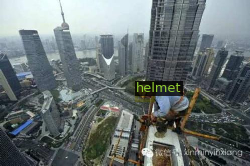

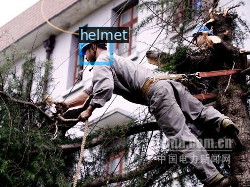

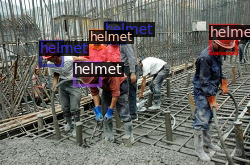

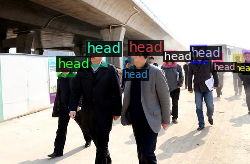

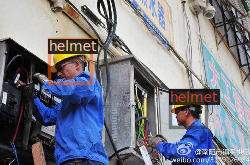

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("exp_train")
dataset_dicts = DatasetCatalog.get("exp_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

### Training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("exp_train")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
#cfg.MODEL.DEVICE = "cpu"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/16 11:02:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/coco/annotations/instances_val2017.json'

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("exp_train", )
predictor = DefaultPredictor(cfg)

[03/16 11:04:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


### Visualizing Results

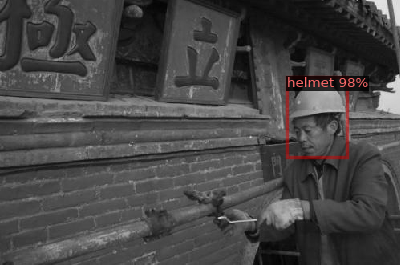

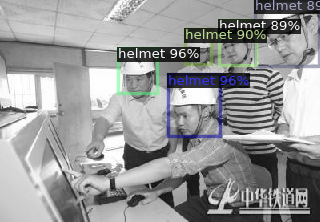

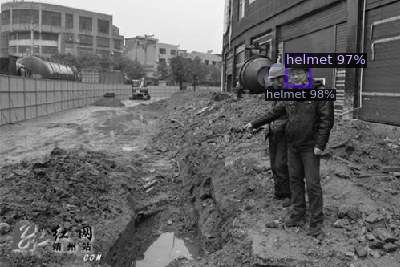

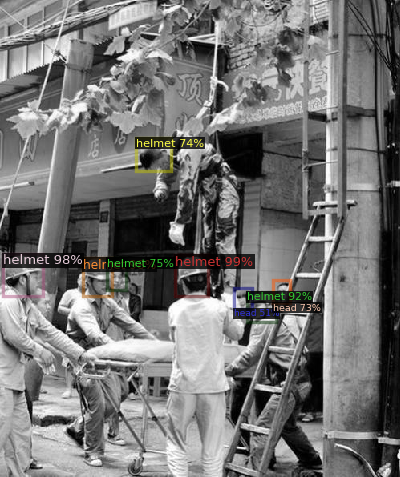

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, # Use the correct metadata variable
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

### Evaluation

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("exp_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "exp_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/16 11:05:23 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/16 11:05:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/16 11:05:23 d2.data.datasets.coco]: Loaded 706 images in COCO format from /content/drive/MyDrive/Detectron2_Dataset/test/_annotations.coco.json
[03/16 11:05:23 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  Workers   | 0            |    head    | 726          |   helmet   | 1915         |
|   person   | 64           |            |              |            |              |
|   total    | 2705         |            |              |            |              |
[03/16 11:05:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference:

### Getting the custom config file

In [ ]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()